In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import numpyro
except ImportError:
    %pip uninstall -y jax jaxlib
    %pip install -q numpyro jax jaxlib

try:
    import arviz
except ImportError:
    %pip install arviz

(classification)=

## GP for Classification

In this tutorial, we demonstrate Classification task using GP in `tinygp`. In case of classification, the test predications are the class probabilities.

Instead of target values being in real space, the target values are in discrete values corresponding to the respective classes. In GP Classification, we use a "link function" to link the real output of the GP to the probabilistic distribution of the classes. We use a GP prior on the latent function which is then squashed down using the link function.

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [3]:
import numpyro
import numpyro.distributions as dist

We start with binary classification on a simple XOR Dataset.  
As the classification is binary, the discrete target values are in $[0, 1]$ for Class 1 and Class 2 respectively.

We model the binary class probabilities with Bernoulli distribution with parameter `p`, the probability of class $2$.  
The `link function` we use for squashing the GP prior to range $[0, 1]$ for the `p` is the Sigmoid function.

For binary classification, we build on our model from GP regression and use:
$$ f \sim \mathcal{G P}\left(0, \mathbf{K}_{f}\left(x, x^{\prime}\right)\right)$$
with a sigmoid likelihood
$$ p(y=1 \mid f)=\operatorname{Sigmoid}(f)$$
or
$$
y \sim \text { Bernoulli(Sigmoid(f)) }
$$

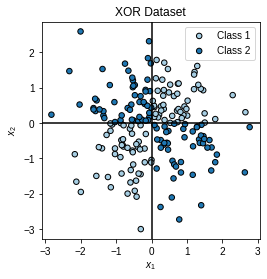

In [4]:
X = jax.random.normal(jax.random.PRNGKey(1234), (200, 2))
y = jnp.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

c = plt.cm.get_cmap("Paired")(y)
plt.scatter(
    X[:, 0][y==0], X[:, 1][y==0], s=30, c=c[y==0], cmap=plt.cm.Paired, edgecolors=(0, 0, 0), label=f"Class 1"
)
plt.scatter(
    X[:, 0][y==1], X[:, 1][y==1], s=30, c=c[y==1], cmap=plt.cm.Paired, edgecolors=(0, 0, 0), label=f"Class 2"
)
plt.gca().set_aspect("equal")
plt.axhline(0, color="k")
plt.axvline(0, color="k")
plt.xlabel(r"$x_{1}$")
plt.ylabel(r"$x_{2}$")
plt.legend()
_ = plt.title("XOR Dataset")

In [5]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T
true_X = jnp.vstack((xx.ravel(), yy.ravel())).T
true_y = jnp.logical_xor(true_X[:, 0] > 0, true_X[:, 1] > 0)

In [6]:
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

As the likelihood is non-Gaussian we need to use Markov Chain Monte Carlo (MCMC) or Variational Inference (VI) to marginalize numerically.  
This follows from the example in {ref}`markov-chain-monte-carlo-mcmc` and {ref}`sampling-with-numpyro`.

In [7]:
import jax
import jax.numpy as jnp
from flax.linen.initializers import zeros
import numpyro
import numpyro.distributions as dist
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

def model(x, y = None):
    # The parameters of the GP regression
    mean = numpyro.param("mean", jnp.zeros(()))
    sigma = numpyro.param("sigma", jnp.ones(()))
    ell = numpyro.param("ell", jnp.ones(()))

    # Set up the kernel and GP objects
    kernel = (sigma ** 2) * kernels.ExpSquared(scale = ell)
    gp = GaussianProcess(kernel, x, diag=1e-5, mean = mean)

    gp_out = numpyro.sample("gp_out", gp.numpyro_dist())
    # Squashing the GP regression real output to the [0, 1] range 
    # using sigmoid as the link function
    p = sigmoid(gp_out)

    # Finally our observation model is Bernoulli distribution 
    # where 'p' is the probability of Class 2
    numpyro.sample("obs", dist.Bernoulli(probs = p), obs = y)

    if y is not None:
        # Posterior Inference on true_X input values
        numpyro.deterministic("pred", gp.condition(gp_out, true_X).gp.loc)

nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.8)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(55873)

/tmp/ipykernel_544400/1971183216.py:34: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


In [8]:
%%time
# run the MCMC
mcmc.run(rng_key, X, y=y,)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready() # Blocking to get timing right

sample: 100%|██████████| 2000/2000 [01:09<00:00, 28.87it/s, 1023 steps of size 2.87e-03. acc. prob=0.87]


CPU times: user 44min 11s, sys: 1h 44min 20s, total: 2h 28min 31s
Wall time: 2min 39s


As MCMC is an iterative method, we need to check the convergence.

In [9]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gp_out[0],0.954,0.365,0.257,1.617,0.042,0.030,75.0,158.0,1.01
gp_out[1],-2.544,0.506,-3.438,-1.575,0.064,0.045,67.0,186.0,1.04
gp_out[2],-1.648,0.385,-2.404,-0.945,0.046,0.032,72.0,115.0,1.02
gp_out[3],0.119,0.324,-0.452,0.742,0.044,0.031,55.0,122.0,1.02
gp_out[4],-0.292,0.351,-0.989,0.352,0.036,0.026,95.0,140.0,1.01
...,...,...,...,...,...,...,...,...,...
gp_out[195],0.157,0.325,-0.389,0.774,0.047,0.033,49.0,84.0,1.02
gp_out[196],2.005,0.543,0.926,2.972,0.048,0.034,131.0,335.0,1.02
gp_out[197],0.800,0.359,0.112,1.466,0.040,0.029,79.0,226.0,1.01
gp_out[198],-0.077,0.355,-0.845,0.522,0.042,0.030,73.0,106.0,1.04


In the above diagnostic report, the `R-hat` is less than $1.05$ in all parameters, so the method had converged and we are good to proceed with the samples.

Now we look at the train accuracy.  
From the samples, we get `gp_out`, which is the output of the GP regression model on the train points. To convert to class probabilities, we use the Sigmoid as the link function.
Finally we end up with probabilites of Class 2. For deterministically assigning classes, $p > 0.5$ would be assigned Class 2 and $p <= 0.5$ is assigned Class 1. 

In [10]:
q = np.percentile(samples["gp_out"], [5, 25, 50, 75, 95], axis=0)
y_hat = sigmoid(q[2]) > 0.5

print(f"Train Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Train Accuracy: 97.00%


We see that our model did a reasonable job and got a good accuracy on the train data.     
We now visualize the predictions on 2D grid points `true_X`. `pred` are the GP regression model output samples on 2D grid points.  

In [11]:
q = np.percentile(samples["pred"], [5, 25, 50, 75, 95], axis=0)
true_y_hat = sigmoid(q[2]) > 0.5
print(f"Test Accuracy: {(true_y_hat==true_y).sum()*100/(len(true_y)) :0.2f}%")

Test Accuracy: 97.16%


In [12]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            sigmoid(q[2]).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

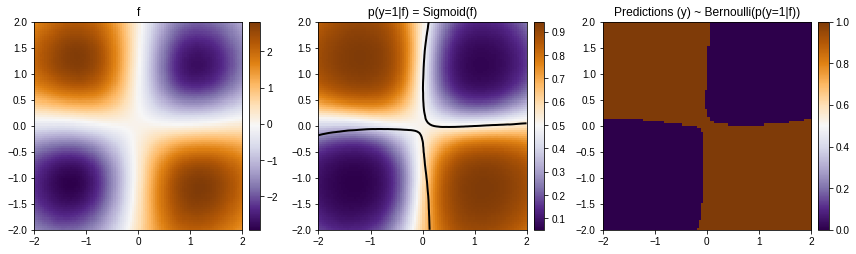

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
plot_pred_2d(q[2].reshape(xx.shape), xx, yy, ax=ax[0], title="f")
plot_pred_2d(
    sigmoid(q[2]).reshape(xx.shape),
    xx,
    yy,
    ax=ax[1],
    title="p(y=1|f) = Sigmoid(f)",
    contour=True,
)
plot_pred_2d(true_y_hat.reshape(xx.shape), xx, yy, ax=ax[2], title="Predictions (y) ~ Bernoulli(p(y=1|f))")

fig.tight_layout()